In [2]:
import qrcode
import pickle
import numpy as np
import itertools
import matplotlib.pyplot as plt

from enum import Enum, auto
from typing import List, Callable

from scripts.GF256_Number import GF256_Number

In [3]:
%%HTML
<h3>Ziele</h3>
<ul style="list-style: none; padding-left: 0;">
    <li><input type="checkbox" checked> Grobe Datenanalyse/Datenverwaltung: Passende Kodierung wählen (numerisch, alphanumerisch, Byte (Latin-1) und Kanji (shift JIS))</li>
    <li><input type="checkbox" checked> Minimale Version (bzw. Größe) berechnen, padding und in Codewörter unterteilen</li>
    <li><input type="checkbox" checked> Error Correction Coding: Redundante Bytes zur Fehlerbehebung berechnen (Reed-Solomon-Code)</li>
    <li><input type="checkbox" checked> Zahlen im Galois-Feld GF(256)</li>
    <li><input type="checkbox" checked> Generator-Polynom und Message-Polynom erstellen</li>
    <li><input type="checkbox" checked> Polynomen Division</li>
    <li><input type="checkbox" checked> Die Daten passend sortieren, sodass der QR-Code gefüllt werden kann</li>
    <li><input type="checkbox" checked> Den QR-Code mit function patterns füllern</li>
    <li><input type="checkbox" checked> Die QR-Code Matrix mit den Daten und dessen Fehlerkorrektur füllen</li>
    <li><input type="checkbox" checked> Maskieren des QR-Codes</li>
    <li><input type="checkbox" checked> Versions Informationen+Fehlerkorrekturbits erstellen</li>
    <li><input type="checkbox" checked> Versions Informationen in den QR-Code einfügen</li>
    <li><input type="checkbox" checked> Format Informationen+Fehlerkorrekturbits erstellen</li>
    <li><input type="checkbox" checked> Format Informationen in den QR-Code einfügen</li>
</ul>

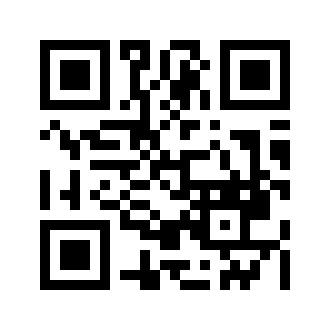

In [4]:
qr = qrcode.QRCode(error_correction=qrcode.ERROR_CORRECT_Q)
# qr.add_data("0"*2000)
# qr.add_data("0"*200)
qr.add_data("hello world!")
# qr.version = 5
qr.make_image()
# qr.add_data("9"*20)
# qr.best_fit()

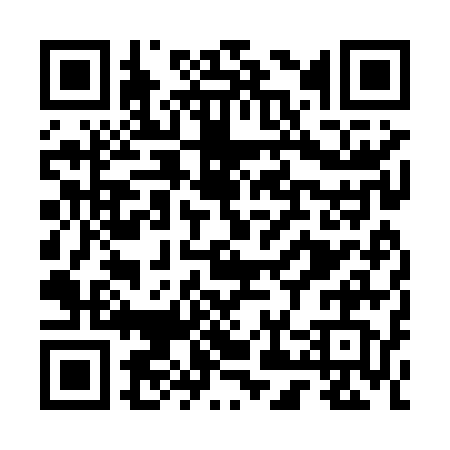

In [5]:
qr = qrcode.QRCode(error_correction=qrcode.ERROR_CORRECT_Q)
# qr.add_data("0"*2000)
# qr.add_data("0"*144)
qr.add_data("hello world!")
qr.version = 5
qr.make_image()
# qr.version
# qr.add_data("9"*20)
# qr.best_fit()

In [6]:
# class ModeIndicator(Enum):
#     numeric_mode = 0b0001
#     alphanumeric_mode = 0b0010
#     byte_mode = 0b0100
#     kanji_mode = 0b1000
#     ECI_mode = 0b0111

# mode_indicator_mapping = {0b0001:0, 0b0010: 1, 0b0100:2, 0b1000:3}

class ModeIndicator(Enum):
    numeric_mode = 0
    alphanumeric_mode = 1
    byte_mode = 2
    kanji_mode = 3
    # ECI_mode = auto()

mode_indicator_mapping = {
    ModeIndicator.numeric_mode: "0001", 
    ModeIndicator.alphanumeric_mode: "0010", 
    ModeIndicator.byte_mode: "0100", 
    ModeIndicator.kanji_mode: "1000"
}

class ErrorCorrectionLevel(Enum):
    L = 1
    M = 2
    Q = 3
    H = 4

class SizeLevel(Enum):
    small = auto()
    medium = auto()
    large = auto()

assert mode_indicator_mapping[ModeIndicator.numeric_mode] == "0001"
assert mode_indicator_mapping[ModeIndicator.alphanumeric_mode] == "0010"
assert mode_indicator_mapping[ModeIndicator.byte_mode] == "0100"
assert mode_indicator_mapping[ModeIndicator.kanji_mode] == "1000"

In [7]:
# size_level
#   Small: 1 to 9
#   Medium: 10 to 26
#   Large: 27 to 40

def get_size_from_version(version: int) -> SizeLevel:
    # if not 0 < version < 41:
    #     raise ValueError(f"the specified version is not between 1 through 40 (inclusive): {version}")
    if 1 <= version <= 9:
        return SizeLevel.small
    if 10 <= version <= 26:
        return SizeLevel.medium
    if 27 <= version <= 40:
        return SizeLevel.large
    raise ValueError(f"the specified version is not between 1 through 40 (inclusive): {version}")

assert get_size_from_version(5) == SizeLevel.small
assert get_size_from_version(9) == SizeLevel.small
assert get_size_from_version(26) == SizeLevel.medium
assert get_size_from_version(40) == SizeLevel.large

In [8]:
char_count_byte_length_for_version_and_mode = {
    SizeLevel.small : {
        ModeIndicator.numeric_mode : 10,
        ModeIndicator.alphanumeric_mode : 9,
        ModeIndicator.byte_mode : 8,
        ModeIndicator.kanji_mode : 8
    },
    SizeLevel.medium : {
        ModeIndicator.numeric_mode : 12,
        ModeIndicator.alphanumeric_mode : 11,
        ModeIndicator.byte_mode : 16,
        ModeIndicator.kanji_mode : 10
    },
    SizeLevel.large : {
        ModeIndicator.numeric_mode : 14,
        ModeIndicator.alphanumeric_mode : 13,
        ModeIndicator.byte_mode : 16,
        ModeIndicator.kanji_mode : 12
    }
}

def get_char_counter_pad(version: int, mode: ModeIndicator):
    return char_count_byte_length_for_version_and_mode[get_size_from_version(version)][mode]

assert get_char_counter_pad(1, ModeIndicator.alphanumeric_mode) == 9
assert get_char_counter_pad(20, ModeIndicator.byte_mode) == 16

def get_char_counter_binary(length: int, version: int, mode: ModeIndicator):
    pad = get_char_counter_pad(version, mode) # get the amount of padding needed
    return format(length, f">0{pad}b")  # pad the binary to the length specified

assert get_char_counter_binary(11, 1, ModeIndicator.alphanumeric_mode) == '000001011'
assert get_char_counter_binary(100, 30, ModeIndicator.alphanumeric_mode) == '0000001100100'

In [9]:
filepath = "../resources/version.pickle"

with open(filepath, "rb") as file:
    version_dict = pickle.load(file)

# version_dict[version-1][ErrorCorrectionLevel.XX][ModeIndicator.YY.value]
# XX: L, M, H, Q
# YY: numeric, alphanumeric, byte, kanji
assert version_dict[0][ErrorCorrectionLevel.M] == [34, 20, 14, 8]

In [10]:
def get_minimum_version(character_length: int, mode: ModeIndicator, error_correction_level: ErrorCorrectionLevel, minimum_version:int=1) -> int:
    """ get the minumum version (equivalent to the size of the qr code) for the specified mode and error correction level
    """
    for index, version in enumerate(version_dict):
        length_in_version = version[error_correction_level][mode.value]
        if length_in_version >= character_length:
            return max(index+1, minimum_version)

    raise Exception("too much data, can't fit inside QR-Code")

assert get_minimum_version(20, ModeIndicator.alphanumeric_mode, ErrorCorrectionLevel.M, minimum_version=10) == 10
assert get_minimum_version(2000, ModeIndicator.alphanumeric_mode, ErrorCorrectionLevel.L) == 27
assert get_minimum_version(2000, ModeIndicator.numeric_mode, ErrorCorrectionLevel.Q, minimum_version=26) == 28
assert get_minimum_version(2000, ModeIndicator.byte_mode, ErrorCorrectionLevel.L) == 33
assert get_minimum_version(7089, ModeIndicator.numeric_mode, ErrorCorrectionLevel.L) == 40 # biggest numeric possible

In [11]:
digits = "0123456789" # only digits
alphanumeric = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ $%*+-./:" # digits, cap_alphabet, space, $, %, *, +, -, ., /, :

def get_val_for_char(char):
    return alphanumeric.find(char)

assert get_val_for_char('A') == 10
assert get_val_for_char(':') == 44

def get_char_for_val(val):
    return alphanumeric[val]

assert get_char_for_val(10) == 'A'
assert get_char_for_val(44) == ':'

In [12]:
def get_mode(data):
    if set(data).issubset(digits): # or use re.match
        return ModeIndicator.numeric_mode
    elif set(data).issubset(alphanumeric):
        return ModeIndicator.alphanumeric_mode
    # elif # kanji
    #     print("use kanji mode")
        # mode_indicator = ModeIndicator.kanji_mode
    else:
        return ModeIndicator.byte_mode

assert get_mode("12434") == ModeIndicator.numeric_mode
assert get_mode("HELLO WORLD*+-123") == ModeIndicator.alphanumeric_mode
assert get_mode("324kjdsfSFJ!") == ModeIndicator.byte_mode

# not implemented:
#   - Extended Channel Interpretation (ECI) mode
#   - Structured Append mode
#   - FNC1 mode

In [13]:
# https://www.thonky.com/qr-code-tutorial/alphanumeric-mode-encoding
def encode_alphanumeric(data: str) -> str:
    encoded_data = ""
    pairs = [data[i:i+2] for i in range(0, len(data), 2)]
    
    for pair in pairs:
        if len(pair) == 1:
            val = get_val_for_char(pair)
            encoded_data += format(val, ">06b")
            break
        
        val1 = get_val_for_char(pair[0])
        val2 = get_val_for_char(pair[1])
        pair_val = (45*val1)+val2

        encoded_data += format(pair_val, ">011b")
    return encoded_data

assert encode_alphanumeric("HELLO WORLD") == '0110000101101111000110100010111001011011100010011010100001101'


# https://www.thonky.com/qr-code-tutorial/numeric-mode-encoding
def encode_numeric(data: str) -> str:
    encoded_data = ""
    pairs = [data[i:i+3] for i in range(0, len(data), 3)]

    for pair in pairs:
        if len(pair) == 1 or pair[0:2] == "00":
            encoded_data += format(int(pair), ">04b")
        elif len(pair) == 2 or pair[0] == "0":
            encoded_data += format(int(pair), ">07b")
        elif len(pair) == 3:
            encoded_data += format(int(pair), ">010b")
    return encoded_data

assert encode_numeric("8675309") == '110110001110000100101001'


# https://www.thonky.com/qr-code-tutorial/byte-mode-encoding
def encode_byte(data: str) -> str:
    data_bytes = data.encode("ISO 8859-1") # iso 8859 latin-1 (Western europe)
    # data_bytes = data.encode("UTF-8")

    encoded_data = "".join(format(byte, "0>8b") for byte in data_bytes)
    return encoded_data

assert encode_byte("Hello, world!") == '01001000011001010110110001101100011011110010110000100000011101110110111101110010011011000110010000100001'


# https://www.thonky.com/qr-code-tutorial/kanji-mode-encoding
def encode_kanji(data):
    raise NotImplementedError

def encode_data(data, mode):
    if mode == ModeIndicator.numeric_mode:
        return encode_numeric(data)
    elif mode == ModeIndicator.alphanumeric_mode:
        return encode_alphanumeric(data)
    elif mode == ModeIndicator.byte_mode:
        return encode_byte(data)
    elif mode == ModeIndicator.kanji_mode:
        return encode_kanji(data)

In [14]:
filepath = "../resources/error_correction_table.pickle"

with open(filepath, "rb") as file:
    error_correction_dict = pickle.load(file)

# error_correction_dict[(version, ErrorCorrectionLevel)][XX]
# XX: Total Number of Data Codewords, EC Codewords Per Block, Number of Blocks in Group 1, 
#     Number of Data Codewords in Each of Group 1's Blocks, Number of Blocks in Group 2, Number of Data Codewords in Each of Group 2's Blocks

assert error_correction_dict[(40, ErrorCorrectionLevel.H)] == (1276, 30, 20, 15, 61, 16)

In [15]:
def get_total_codewords(version: int, error_correction_level: ErrorCorrectionLevel) -> int:
    return error_correction_dict[(version, error_correction_level)][0]

assert get_total_codewords(1, ErrorCorrectionLevel.Q) == 13
assert get_total_codewords(40, ErrorCorrectionLevel.H) == 1276

def get_data_bits_required(version: int, error_correction_level: ErrorCorrectionLevel) -> int:
    return error_correction_dict[(version, error_correction_level)][0]*8

assert get_data_bits_required(20, ErrorCorrectionLevel.H) == 3080
assert get_data_bits_required(1, ErrorCorrectionLevel.Q) == 104

In [16]:
def get_blocks_per_group(version: int, error_correction_level: ErrorCorrectionLevel) -> List[int]:
    error_correction_info = error_correction_dict[(version, error_correction_level)]
    return [error_correction_info[2], error_correction_info[4]]

assert get_blocks_per_group(1, ErrorCorrectionLevel.Q) == [1, 0]
assert get_blocks_per_group(5, ErrorCorrectionLevel.Q) == [2, 2]
assert get_blocks_per_group(40, ErrorCorrectionLevel.L) == [19, 6]
assert get_blocks_per_group(33, ErrorCorrectionLevel.M) == [14, 21]

In [17]:
def get_codewords_per_block(version: int, error_correction_level: ErrorCorrectionLevel) -> List[int]:
    error_correction_info = error_correction_dict[(version, error_correction_level)]
    return [error_correction_info[3], error_correction_info[5]]

assert get_codewords_per_block(1, ErrorCorrectionLevel.Q) == [13, 0]
assert get_codewords_per_block(5, ErrorCorrectionLevel.Q) == [15, 16]
assert get_codewords_per_block(40, ErrorCorrectionLevel.L) == [118, 119]
assert get_codewords_per_block(33, ErrorCorrectionLevel.M) == [46, 47]

In [18]:
def get_error_correction_codewords_per_block(version: int, error_correction_level: ErrorCorrectionLevel) -> int:
    error_correction_info = error_correction_dict[(version, error_correction_level)]
    return error_correction_info[1]

assert get_error_correction_codewords_per_block(1, ErrorCorrectionLevel.M) == 10
assert get_error_correction_codewords_per_block(40, ErrorCorrectionLevel.H) == 30

In [19]:
def add_terminator(total_bit_string: str, total_data_bits_required: int) -> str:
    """ returns the total bit string with the terminator appended
    """
    diffrence = total_data_bits_required - len(total_bit_string)
    terminator_length = min(4, diffrence)
    return total_bit_string + "0" * terminator_length

assert add_terminator('00100000010110110000101101111000110100010111001011011100010011010100001101', 104) == "001000000101101100001011011110001101000101110010110111000100110101000011010000"
# assert add_terminator('01000000000101100001', 104) == "010000000001011000010000"

In [20]:
def add_padding(total_bit_string: str) -> str:
    pad_length = 8-len(total_bit_string)%8
    return  total_bit_string + "0" * pad_length

assert add_padding("001000000101101100001011011110001101000101110010110111000100110101000011010000") == "00100000010110110000101101111000110100010111001011011100010011010100001101000000"

In [21]:
def fill_with_pad_bytes(total_bit_string: str, total_data_bits_required: int) -> str:
    """ fill the total_bit_string with the pad_bytes, alternating
    """
    pad_byte1, pad_byte2 = "11101100", "00010001"

    while len(total_bit_string) < total_data_bits_required:
        total_bit_string += pad_byte1
        pad_byte1, pad_byte2 = pad_byte2, pad_byte1

    return total_bit_string

assert len(fill_with_pad_bytes("00100000010110110000101101111000110100010111001011011100010011010100001101000000", 104)) == 104
assert fill_with_pad_bytes("00100000010110110000101101111000110100010111001011011100010011010100001101000000", 104) == "00100000010110110000101101111000110100010111001011011100010011010100001101000000111011000001000111101100"

In [22]:
def split_string_into_chunks(string, chunk_size=8):
    """ split a string into evenly sized chunks
    """
    return [string[index:(index+chunk_size)] for index in range(0, len(string), chunk_size)]

In [23]:
def split_in_groups(codewords: List[str], num_of_blocks_per_group: List[int], num_of_codewords_per_block: List[int]) -> List[List[List[str]]]:
    """
    The codewords need to be sorted into 2 Groups, each containing x and y blocks respectivly
    In Group 1 each Block contains n codewords, in Group 2 each block contains m codewords

    The codewords need to be sorted into 2 Groups, each containing 'num_of_blocks_per_group[0]' and 'num_of_blocks_per_group[1]' blocks respectivly
    In Group 1 each Block contains 'num_of_codewords_per_block[0]' codewords, in Group 2 each block contains 'num_of_codewords_per_block[1]' codewords
    
    Group 1                 | Group 2
    Block 1 ... Block x     | Block 1 ... Block y
    n or m number of codewords per block
    """
    groups = []
    for group_index in range(2):
        group_offset = group_index*num_of_blocks_per_group[0]*num_of_codewords_per_block[0]
        group = []

        for block_index in range(num_of_blocks_per_group[group_index]):
            block_offset = block_index*num_of_codewords_per_block[group_index]
            
            block = [codewords[group_offset + block_offset + codeword_index_in_block] for codeword_index_in_block in range(num_of_codewords_per_block[group_index])]
            group.append(block)
        groups.append(group)

    return groups

In [24]:
def make_total_bit_string(data: str, error_correction_level: ErrorCorrectionLevel) -> str:
    mode = get_mode(data)
    version = get_minimum_version(len(data), mode, error_correction_level)
    character_count_indicator = get_char_counter_binary(len(data), version, mode)
    encoded_data = encode_data(data, mode)
    total_data_bits_required = get_total_codewords(version, error_correction_level)*8

    total_bit_string = mode_indicator_mapping[mode] + character_count_indicator + encoded_data
    total_bit_string = fill_with_pad_bytes(add_padding(add_terminator(total_bit_string, total_data_bits_required)), total_data_bits_required)
    
    return total_bit_string 

assert make_total_bit_string("HELLO WORLD", ErrorCorrectionLevel.Q) == "00100000010110110000101101111000110100010111001011011100010011010100001101000000111011000001000111101100"

In [25]:
def make_groups(data: str, error_correction_level: ErrorCorrectionLevel) -> str: # just current name # TODO: remove?
    mode = get_mode(data)
    version = get_minimum_version(len(data), mode, error_correction_level)
    character_count_indicator = get_char_counter_binary(len(data), version, mode)
    encoded_data = encode_data(data, mode)

    total_data_bits_required = get_total_codewords(version, error_correction_level)*8
    num_of_blocks_per_group = get_blocks_per_group(version, error_correction_level)

    num_of_codewords_per_block = get_codewords_per_block(version, error_correction_level)
    total_codewords = get_total_codewords(version, error_correction_level)
    num_of_error_correction_codewords = get_error_correction_codewords_per_block(version, error_correction_level)

    total_bit_string = mode_indicator_mapping[mode] + character_count_indicator + encoded_data
    total_bit_string = fill_with_pad_bytes(add_padding(add_terminator(total_bit_string, total_data_bits_required)), total_data_bits_required)
    
    codewords = split_string_into_chunks(total_bit_string, 8)

    assert all(len(codeword) == 8 for codeword in codewords)

    groups = split_in_groups(codewords, num_of_blocks_per_group, num_of_codewords_per_block)

    return groups

assert make_groups("HELLO WORLD", ErrorCorrectionLevel.Q) == [[['00100000', '01011011', '00001011', '01111000', '11010001', '01110010', '11011100', '01001101', '01000011', '01000000', '11101100', '00010001', '11101100']], []]

In [26]:
# generator Polynomial

def multiply_terms(term1, term2):
    result = []

    for coefficient1, exponent1 in term1:
        for coefficient2, exponent2 in term2:
            result.append((coefficient1*coefficient2, exponent1+exponent2))

    return result

def combine(term):
    result = [None]*len(term)

    for coefficient, exponent in term:
        if result[exponent] is None:
            result[exponent] = coefficient
        else:
            result[exponent] += coefficient
            result.pop()
    return [(coefficient, exponent) for exponent, coefficient in reversed(list(enumerate(result)))]

def make_generator_polynomial(error_correction_codewords):

    term = lambda n: [(GF256_Number(alpha=0), 1), (GF256_Number(alpha=n), 0)]

    result = term(0)
    for n in range(1, error_correction_codewords):
        result = combine(multiply_terms(result, term(n)))

    return [coefficient for coefficient, exponent in result]


[coefficient.integer for coefficient in make_generator_polynomial(7)]
# result = make_generator_polynomial(7)
# print(" + ".join([f"a^{coefficient.alpha}*x^{exponent}" for coefficient, exponent in result]))
# print("a^0*x^7 + a^87*x^6 + a^229*x^5 + a^146*x^4 + a^149*x^3 + a^238*x^2 + a^102*x^1 + a^21*x^0")
# result = [coefficient for coefficient, exponent in result]
# result

[1, 127, 122, 154, 164, 11, 68, 117]

In [27]:
# test with a Q-5 qr code
test_Q5_total_bit_string = "0100001101010101010001101000011001010111001001100101010111000010011101110011001000000110000100100000011001100111001001101111011011110110010000100000011101110110100001101111001000000111001001100101011000010110110001101100011110010010000001101011011011100110111101110111011100110010000001110111011010000110010101110010011001010010000001101000011010010111001100100000011101000110111101110111011001010110110000100000011010010111001100101110000011101100000100011110110000010001111011000001000111101100"
test_Q5_version = 5
test_Q5_error_correction_level = ErrorCorrectionLevel.Q
test_Q5_result = [[['01000011', '01010101', '01000110', '10000110', '01010111', '00100110', '01010101', '11000010', '01110111', '00110010', '00000110', '00010010', '00000110', '01100111', '00100110'], ['11110110', '11110110', '01000010', '00000111', '01110110', '10000110', '11110010', '00000111', '00100110', '01010110', '00010110', '11000110', '11000111', '10010010', '00000110']], [['10110110', '11100110', '11110111', '01110111', '00110010', '00000111', '01110110', '10000110', '01010111', '00100110', '01010010', '00000110', '10000110', '10010111', '00110010', '00000111'], ['01000110', '11110111', '01110110', '01010110', '11000010', '00000110', '10010111', '00110010', '11100000', '11101100', '00010001', '11101100', '00010001', '11101100', '00010001', '11101100']]]

test_Q5_num_of_blocks_per_group = get_blocks_per_group(test_Q5_version, test_Q5_error_correction_level)
test_Q5_num_of_codewords_per_block = get_codewords_per_block(test_Q5_version, test_Q5_error_correction_level)
test_Q5_total_codewords = get_total_codewords(test_Q5_version, test_Q5_error_correction_level)

test_Q5_codewords = split_string_into_chunks(test_Q5_total_bit_string, 8)
assert all(len(test_Q5_codeword) == 8 for test_Q5_codeword in test_Q5_codewords)

test_Q5_groups = split_in_groups(test_Q5_codewords, test_Q5_num_of_blocks_per_group, test_Q5_num_of_codewords_per_block)
assert test_Q5_groups == test_Q5_result

In [28]:
def polynomial_long_division_gf256(message_polynomial, generator_polynomial):

    def polynomial_long_division_gf256_step(message_polynomial, generator_polynomial):
        # Multiply the generator_polynomial by the lead term of the messenger_polynomial
        lead_coefficient_message = message_polynomial[0]
        result = [coefficent*lead_coefficient_message for coefficent in generator_polynomial]
        
        # XOR the result with the messenger Polynomial (fill with integer=0)
        coefficient_pairs = itertools.zip_longest(message_polynomial, result, fillvalue=GF256_Number(integer=0))
        result = [message_coefficient + result_1a_coefficient for message_coefficient, result_1a_coefficient in coefficient_pairs]

        # discard leading zero
        result = result[1:]
        return result

    result = message_polynomial
    for index in range(len(message_polynomial)):
        result = polynomial_long_division_gf256_step(message_polynomial=result, generator_polynomial=generator_polynomial)
    
    return result

# print(message_polynomial)
# error_correction_codewords = polynomial_long_division_gf256(message_polynomial, make_generator_polynomial(10))
# print(error_correction_codewords)

In [29]:
def interweave(codewords: list) -> list:
    # flatten, to make one array of blocks
    flattened = sum(codewords, [])
    # zip together all the blocks
    zipped = itertools.zip_longest(*flattened, fillvalue=None)
    # remove all 'None's and flatten again
    result = list(filter(lambda value: value is not None, sum(zipped, ())))
    return result

test_codewords = [
    [
        [
            [67, 85, 70, 134, 87, 38, 85, 194, 119, 50, 6, 18, 6, 103, 38],
            [246, 246, 66, 7, 118, 134, 242, 7, 38, 86, 22, 198, 199, 146, 6]
        ],
        [
            [182, 230, 247, 119, 50, 7, 118, 134, 87, 38, 82, 6, 134, 151, 50, 7],
            [70,247,118,86,194,6,151,50,16,236,17,236,17,236,17,236]
        ]
    ],
    [
        [
            [213, 199, 11, 45, 115, 247, 241, 223, 229, 248, 154, 117, 154, 111, 86, 161, 111, 39],
            [87, 204, 96, 60, 202, 182, 124, 157, 200, 134, 27, 129, 209, 17, 163, 163, 120, 133]
        ],
        [
            [148, 116, 177, 212, 76, 133, 75, 242, 238, 76, 195, 230, 189, 10, 108, 240, 192, 141],
            [235, 159, 5, 173, 24, 147, 59, 33, 106, 40, 255, 172, 82, 2, 131, 32, 178, 236]
        ]
    ]
]


fin = [67, 246, 182, 70, 85, 246, 230, 247, 70, 66, 247, 118, 134, 7, 119, 86, 87, 118, 50, 194, 38, 134, 7, 6, 85, 242, 118, 151, 194, 7, 134, 50, 119, 38, 87, 16, 50, 86, 38, 236, 6, 22, 82, 17, 18, 198, 6, 236, 6, 199, 134, 17, 103, 146, 151, 236, 38, 6, 50, 17, 7, 236]
fin_err = [213, 87, 148, 235, 199, 204, 116, 159, 11, 96, 177, 5, 45, 60, 212, 173, 115, 202, 76, 24, 247, 182, 133, 147, 241, 124, 75, 59, 223, 157, 242, 33, 229, 200, 238, 106, 248, 134, 76, 40, 154, 27, 195, 255, 117, 129, 230, 172, 154, 209, 189, 82, 111, 17, 10, 2, 86, 163, 108, 131, 161, 163, 240, 32, 111, 120, 192, 178, 39, 133, 141, 236]

assert interweave(test_codewords[0]) == fin
assert interweave(test_codewords[1]) == fin_err

In [30]:
with open('../resources/remainder_bits.pickle', 'rb') as file:
    # Load the array from the file using pickle
    remainder_bits_table = pickle.load(file)

def get_remainder_bits(version: int) -> int:
    if not 1 <= version <= 40:
        raise ValueError(f"the version needs to be in the range 1 through 40")
    return remainder_bits_table[version-1]

assert get_remainder_bits(40) == 0
assert get_remainder_bits(1) == 0

In [31]:
def make_groups(data: str, error_correction_level: ErrorCorrectionLevel, version=None) -> tuple: # just current name # TODO: just temp function, group functions better
    
    # ENCODING PHASE - check

    mode = get_mode(data)
    # version = version if version is not None else get_minimum_version(len(data), mode, error_correction_level)
    min_version = get_minimum_version(len(data), mode, error_correction_level)
    version = max(version, min_version) if version is not None else min_version
    encoded_data = encode_data(data, mode)

    total_data_bits_required = get_total_codewords(version, error_correction_level)*8

    character_count_indicator = get_char_counter_binary(len(data), version, mode)
    total_bit_string = mode_indicator_mapping[mode] + character_count_indicator + encoded_data
    total_bit_string = fill_with_pad_bytes(add_padding(add_terminator(total_bit_string, total_data_bits_required)), total_data_bits_required)
    
    # ERROR CORRECTION PHASE - check

    # total_codewords = get_total_codewords(version, error_correction_level)
    codewords = split_string_into_chunks(total_bit_string, 8)

    assert all(len(codeword) == 8 for codeword in codewords)

    num_of_blocks_per_group = get_blocks_per_group(version, error_correction_level)
    num_of_codewords_per_block = get_codewords_per_block(version, error_correction_level)
    data_codewords_in_groups = split_in_groups(codewords, num_of_blocks_per_group, num_of_codewords_per_block)

    num_of_error_correction_codewords = get_error_correction_codewords_per_block(version, error_correction_level)
    generator_polynomial = make_generator_polynomial(num_of_error_correction_codewords)

    error_correction_codewords_in_groups = []

    # convert data_codewords from binary to integers
    for group_index, group in enumerate(data_codewords_in_groups):
        for block_index, block in enumerate(group):
            data_codewords_in_groups[group_index][block_index] = [int(codeword, 2) for codeword in block]

    # make the error_correction_codewords and arange them into groups and blocks
    for group in data_codewords_in_groups:
        error_correction_codewords_single_group = []
        for block in group:
            message_polynomial = [GF256_Number(integer=codeword) for codeword in block]
            error_correction_codewords_single_block = polynomial_long_division_gf256(message_polynomial, generator_polynomial)
            error_correction_codewords_single_block = [codeword.integer for codeword in error_correction_codewords_single_block] # convert to integers
            error_correction_codewords_single_group.append(error_correction_codewords_single_block)
        error_correction_codewords_in_groups.append(error_correction_codewords_single_group)


    # STRUCTURE_PHASE - TODO

    # interweave if there is more than one block
    # => interweave if there are just blocks in group 1
    if sum(num_of_blocks_per_group) > 1:
        final_message = interweave(data_codewords_in_groups) + interweave(error_correction_codewords_in_groups)
    else:
        # else just use 1 block:
        final_message = data_codewords_in_groups[0][0] + error_correction_codewords_in_groups[0][0]

    num_remainder_bits = get_remainder_bits(version)
    # print(num_remainder_bits)

    bits = ''.join(format(byte, '08b') for byte in final_message) + '0'*num_remainder_bits

    # END STRUCTURE_PHASE

    return version, bits

version, out = make_groups("HELLO WORLD", ErrorCorrectionLevel.Q, version=5)
# a = make_groups("HELLO WORLD", ErrorCorrectionLevel.M)
print(f"{len(out)}")
print(out)
# version 7: len(out) == 1568
# version 5: len(out) == 1079

1079
00100000000100011110110011101100010110111110110000010001000100010000101100010001111011001110110001111000111011000001000100010001110100010001000111101100111011000111001011101100000100010001000111011100000100011110110011101100010011011110110000010001000100010100001100010001111011001110110001000000111011000001000100010001111011000001000111101100111011000001000111101100000100010001000111101100000100011110110011101100000100011110110000010001000100011110110000010001111011001110110000010001000100011000110100001000111111011111110111001000011111111101000011010000011100010011101011010000110100001001101111010101110111101101111001100101010001011001010010010100111111010101011000100101001001011101001111010001100011011000110110001001001000101000001010000010111001100000010011100011111000110000110011001110001100000011000000100101010010111011011010110110010111011110010111110001111100010011010001010010011001110110011100000110011101011111110111111101101101001111010100100101001001011001000011111101000

In [32]:
class Module(Enum):
    black = auto()
    white = auto()
    empty = auto()
    data_white = auto()
    data_black = auto()
    reserved_for_format_information = auto()
    reserved_for_version_information = auto()

symbols = {
    Module.empty: ' ',
    Module.white: '_',
    Module.black: '#',
    Module.data_white: 'o',
    Module.data_black: '+',
    Module.reserved_for_format_information: 'x',
    Module.reserved_for_version_information: 'y'
}
symbols1 = {
    Module.empty: ' ',
    Module.white: '_',
    Module.black: '#',
    Module.data_white: '_',
    Module.data_black: '#',
    Module.reserved_for_format_information: 'x',
    Module.reserved_for_version_information: 'y'
}

In [33]:
matrix = np.full((5, 5), Module.empty)

def pp_mat(mat, sep=".", verbose=True):
    if verbose:
        for row in mat:
            print(sep.join([symbols[e] for e in row]))
    else:
        print(" " + sep + sep.join([str(i) for i in range(len(mat[0]))]))
        for index, row in enumerate(mat):
            print(str(index)+ sep + sep.join([symbols1[e] for e in row]))

pp_mat(matrix)

 . . . . 
 . . . . 
 . . . . 
 . . . . 
 . . . . 


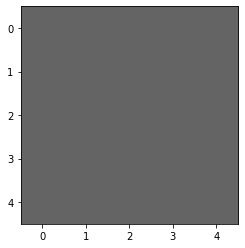

In [34]:
def hex_to_rgb(hex_code):
    """Converts a hexadecimal color code to RGB values."""
    r = float(int(hex_code[1:3], 16)/255)
    g = float(int(hex_code[3:5], 16)/255)
    b = float(int(hex_code[5:7], 16)/255)
    return (r, g, b)

hex_to_rgb("#646464")

cmap = {
    Module.empty: hex_to_rgb("#646464"),
    Module.white: hex_to_rgb("#ffffff"),
    Module.black: hex_to_rgb("#000000"),
    Module.data_white: hex_to_rgb("#ffffdf"),
    Module.data_black: hex_to_rgb("#000050"),
    Module.reserved_for_format_information: hex_to_rgb("#0000ff"),
    Module.reserved_for_version_information: hex_to_rgb("#00ff00")
}

def display_QR(matrix):
    vecfunc = np.vectorize(lambda x: cmap[x])
    rgb_arr = np.array(vecfunc(matrix))
    rgb_arr = rgb_arr.transpose(1, 2, 0)
    plt.imshow(rgb_arr)
    plt.show()

display_QR(matrix)

In [83]:
def calc_finder_positions(version: int) -> tuple:
    """ returns the top left corners of the finder positions
    """
    return (0, 0), ((((version-1)*4)+21) - 7, 0), (0, (((version-1)*4)+21) - 7)

# def calc_finder_positions1(version: int) -> tuple:
#     size = (((version-1)*4)+21)

#     # top left corners of finder patterns
#     top_left_finder_pos = (0, 0)
#     top_right_finder_pos = (size-7, 0)
#     bottom_left_finder_pos = (0, size-7)

#     return top_left_finder_pos, top_right_finder_pos, bottom_left_finder_pos

# assert all([calc_finder_positions(i) == calc_finder_positions1(i) for i in range(1, 41)])
calc_finder_positions(11)

((0, 0), (54, 0), (0, 54))

In [36]:
def calc_size(version: int) -> int:
    return (((version-1)*4)+21)

In [37]:
version = 5
size = calc_size(version)
# top left corners of finder patterns
top_left_finder_pos, top_right_finder_pos, bottom_left_finder_pos = calc_finder_positions(version)

print(size, top_left_finder_pos, top_right_finder_pos, bottom_left_finder_pos)

37 (0, 0) (30, 0) (0, 30)


In [38]:
FINDER_PATTERN = np.array(
    [
        [Module.black, Module.black, Module.black, Module.black, Module.black, Module.black, Module.black],
        [Module.black, Module.white, Module.white, Module.white, Module.white, Module.white, Module.black],
        [Module.black, Module.white, Module.black, Module.black, Module.black, Module.white, Module.black],
        [Module.black, Module.white, Module.black, Module.black, Module.black, Module.white, Module.black],
        [Module.black, Module.white, Module.black, Module.black, Module.black, Module.white, Module.black],
        [Module.black, Module.white, Module.white, Module.white, Module.white, Module.white, Module.black],
        [Module.black, Module.black, Module.black, Module.black, Module.black, Module.black, Module.black]
    ]
)
ALIGNMENT_PATTERN = np.array(
    [  
        [Module.black, Module.black, Module.black, Module.black, Module.black],
        [Module.black, Module.white, Module.white, Module.white, Module.black],
        [Module.black, Module.white, Module.black, Module.white, Module.black],
        [Module.black, Module.white, Module.white, Module.white, Module.black],
        [Module.black, Module.black, Module.black, Module.black, Module.black]
    ]
)

pp_mat(FINDER_PATTERN, sep=' ')
print()
pp_mat(ALIGNMENT_PATTERN, sep=' ')

# # # # # # #
# _ _ _ _ _ #
# _ # # # _ #
# _ # # # _ #
# _ # # # _ #
# _ _ _ _ _ #
# # # # # # #

# # # # #
# _ _ _ #
# _ # _ #
# _ _ _ #
# # # # #


In [39]:
def place_pattern(matrix: np.ndarray, pattern: np.ndarray, upper_left_corner: tuple, overwrite=True) -> np.ndarray:
    """ 
    place a pattern from a small 2d array into a big 2d array at a certain position
    if overwrite is False, the matrix will not be change if something beside 'Module.empty' would be overwritten
    """

    # Check that the pattern fits within the bounds of the matrix
    if upper_left_corner[0] + len(pattern[0]) > len(matrix[0]) or upper_left_corner[1] + len(pattern) > len(matrix):
        raise ValueError(f"Pattern does not fit within matrix bounds: {upper_left_corner=}, {matrix.shape=}, {pattern.shape=}")

    # Check that the upper_left_corner coordinates are valid
    if upper_left_corner[0] < 0 or upper_left_corner[1] < 0:
        raise ValueError("Upper left corner coordinates must be non-negative")

    end = upper_left_corner[0]+len(pattern[0]), upper_left_corner[1]+len(pattern)

    # only change the matrix if the 'overwrite' flag is set
    if not overwrite:
        area = matrix[upper_left_corner[1]:end[1], upper_left_corner[0]:end[0]]
        if not np.all(area == np.full_like(pattern, fill_value=Module.empty)):
            return matrix
        
    matrix[upper_left_corner[1]:end[1], upper_left_corner[0]:end[0]] = pattern

    # TODO: remove debug statement
    # print(f"{upper_left_corner[0]}:{end[0]}, {upper_left_corner[1]}:{end[1]}")

    return matrix

# upper_left_corner = (2, 3)
# mat = np.zeros((5, 5))
# pat = np.ones((2, 2))

# print(mat)
# place_pattern(mat, pat, upper_left_corner)
# print(mat)

In [40]:
def shift_finder_pattern(pattern: np.ndarray, upper_left_corner: tuple, offset: tuple) -> tuple:
    shifted_pattern = place_pattern(np.full((8, 8), fill_value=Module.white), pattern, offset)
    upper_left_corner = upper_left_corner[0]-offset[0], upper_left_corner[1]-offset[1]
    
    return shifted_pattern, upper_left_corner

# res_pat, res_corn = shift_finder_pattern(FINDER_PATTERN, top_left_finder_pos, (0, 0))
# res_pat, res_corn = shift_finder_pattern(FINDER_PATTERN, top_right_finder_pos, (1, 0))
# res_pat, res_corn = shift_finder_pattern(FINDER_PATTERN, bottom_left_finder_pos, (0, 1))
# pp_mat(res_pat)
# print(res_corn)

In [41]:
# place_pattern(matrix, *shift_finder_pattern(FINDER_PATTERN, top_left_finder_pos, (0, 0)))
# place_pattern(matrix, *shift_finder_pattern(FINDER_PATTERN, top_right_finder_pos, (1, 0)))
# place_pattern(matrix, *shift_finder_pattern(FINDER_PATTERN, bottom_left_finder_pos, (0, 1)))

def place_finder_patterns(matrix: np.ndarray, version: int) -> None:
    finder_pattern_seperator_offsets = [(0, 0), (1, 0), (0, 1)]
    for pos, offset in zip(calc_finder_positions(version), finder_pattern_seperator_offsets):
        place_pattern(matrix, *shift_finder_pattern(FINDER_PATTERN, pos, offset), overwrite=False)


In [42]:
with open('../resources/alignment_pattern_locations_table.pickle', 'rb') as file:
    alignment_pattern_locations_table = pickle.load(file)

In [43]:
def get_alignment_positions(version: int) -> list:
    if not 2 <= version <= 40:
        raise ValueError(f"The QR-Code version must be in the range '2 <= version <= 40' not {version}")

    return list(itertools.product(alignment_pattern_locations_table[version], repeat=2))

# TODO: needs alignement pattern
def place_alignment_patterns(matrix: np.ndarray, version: int) -> None:
    for alignment_position in get_alignment_positions(version):
        upper_left_corner = alignment_position[0]-2, alignment_position[1]-2
        place_pattern(matrix, ALIGNMENT_PATTERN, upper_left_corner, overwrite=False)

get_alignment_positions(2)

[(6, 6), (6, 18), (18, 6), (18, 18)]

In [44]:
# abandonend function
def filter_alignment_positions(version: int, alignment_positions) -> list:
    top_left_finder_pos, top_right_finder_pos, bottom_left_finder_pos = calc_finder_positions(version)

    al_pos = alignment_positions[0]

    # wo dont have to calculate the overlaps, since we can just check during placement

In [45]:
def make_timing_patterns(version: int) -> tuple:
    """ returns horizontal and vertical timing patterns
    """
    # interchanging black and white, but starts with black and ends with black
    length = int((calc_size(version)-16)/2)
    horizontal = np.array([[Module.black, *[Module.white, Module.black]*length]])
    
    return horizontal, np.rot90(horizontal)

def place_timing_patterns(matrix, version: int) -> None:
    horizontal, vertical = make_timing_patterns(version)
    place_pattern(matrix, horizontal, (8, 6))
    place_pattern(matrix, vertical, (6, 8))

In [46]:
def place_dark_module(matrix: np.ndarray, version: int) -> None:
    coords = (8, ((4 * version) + 9))
    matrix[coords[::-1]] = Module.black

In [47]:
# def calc_size(version: int) -> int:
#     return (((version-1)*4)+21)

In [48]:
((4 * version) + 9) == calc_size(version) -8

True

In [49]:
def reserve_format_information_area(matrix: np.ndarray, version: int) -> None:
    def top_left():
        x = 8
        for y in range(0, 6):
            matrix[y, x] = Module.reserved_for_format_information

        y = 8
        for x in range(0, 6):
            matrix[y, x] = Module.reserved_for_format_information

        coords = [(8, 8), (7, 8), (8, 7)]
        for coord in coords:
            matrix[coord] = Module.reserved_for_format_information

    def top_right():
        y = 8
        for x in range(size-8, size):
            matrix[y, x] = Module.reserved_for_format_information
    
    def bottom_left():
        x = 8
        for y in range(size-7, size):
            matrix[y, x] = Module.reserved_for_format_information
    
    size = calc_size(version)

    top_left()
    top_right()
    bottom_left()

In [50]:
def reserve_version_information_area(matrix: np.ndarray, version: int) -> None:
    def top_right():
        pattern = np.full((3, 6), fill_value=Module.reserved_for_version_information)
        upper_left_corner = (0, size-11) # TODO: might be 10
        place_pattern(matrix, pattern, upper_left_corner)

    def bottom_left():
        pattern = np.full((6, 3), fill_value=Module.reserved_for_version_information)
        upper_left_corner = (size-11, 0) # TODO: might be 10
        place_pattern(matrix, pattern, upper_left_corner)

    size = calc_size(version)

    top_right()
    bottom_left()

In [90]:
def place_function_patterns(matrix: np.ndarray, version: int) -> None:
    # TODO: make all theses functions without sideffects
    place_finder_patterns(matrix, version)
    if version >= 2:
        place_alignment_patterns(matrix, version)
    place_timing_patterns(matrix, version)
    place_dark_module(matrix, version)

    
    # if version >= 2:
    #     reserve_format_information_area(matrix, version)
    # if version >= 2:
    reserve_format_information_area(matrix, version)


    if version >= 7:
        reserve_version_information_area(matrix, version)

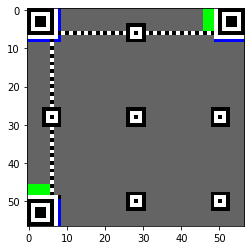

In [52]:
version = 10
matrix = np.full((calc_size(version), calc_size(version)), Module.empty)

place_function_patterns(matrix, version)
display_QR(matrix)

In [53]:
def fill_qr_code(matrix, data_bytes, version):

    def data_bytes_iterator(data):
        temp = 0
        for bit in data:
            temp += 1
            yield Module.data_black if bit == '1' else Module.data_white
        print("you should never have come here, but now that you are here ...") # TODO
        print(f"{temp=}")
        # raise ...
        while True:
            yield Module.black

    bits = data_bytes_iterator(data_bytes)

    matrix = np.rot90(matrix)

    y = 0
    direction = -1 # start with placing modules from right to left
    while y < len(matrix)-1:
        # skip the timing pattern, we should arrive here after a full completion of 2 rows ...
        if y == calc_size(version)-7:
            # print(f"skipping a row:") # TODO: remove
            # pp_mat([matrix[y]])
            y +=1

        for x in range(len(matrix[0]))[::direction]:
            # only fill in data, if the area is not already filled, otherwise skip ...
            if matrix[y, x] == Module.empty:
                matrix[y, x] = next(bits)
            if matrix[y+1, x] == Module.empty:
                matrix[y+1, x] = next(bits)

        y+=2
        direction *= -1 # reverse the module placing direction

    return np.rot90(matrix, k=-1)

    # print(next(bits)) # TODO: if everything works, this should crash the program 
    # raise ...

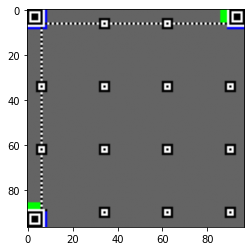

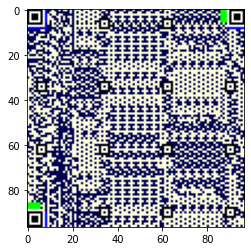

In [54]:
version, out = make_groups("The quick brown fox jumps over the lazy dog", ErrorCorrectionLevel.L, version=20)
matrix = np.full((calc_size(version), calc_size(version)), Module.empty)
place_function_patterns(matrix, version)

display_QR(matrix)
matrix = fill_qr_code(matrix, out, version)
display_QR(matrix)

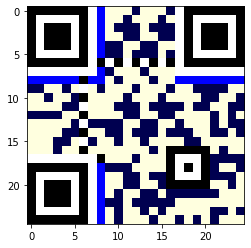

In [55]:
# version, out = make_groups("The quick brown fox jumps over the lazy dog", ErrorCorrectionLevel.L)
version, out = make_groups("HELLO WORLD", ErrorCorrectionLevel.L, version=2)

# FIXME: version 1 somehow iterates over too much data ...
# version, out = make_groups("HELLO WORLD", ErrorCorrectionLevel.L, version=1)
# version, out = make_groups("HELLO WORLD", ErrorCorrectionLevel.L)

# print(f"{version=}")

matrix = np.full((calc_size(version), calc_size(version)), Module.empty)
place_function_patterns(matrix, version)
matrix = fill_qr_code(matrix, out, version)

# print(f"{len(out)=}")
display_QR(matrix)

In [56]:
def get_len(version, ecl=ErrorCorrectionLevel.M):
    return (get_total_codewords(version, ecl) + get_error_correction_codewords_per_block(version, ecl)*sum(get_blocks_per_group(version, ecl)))*8 + get_remainder_bits(version)

print(get_len(15, ErrorCorrectionLevel.H))

5243


version=17
len(out)=6523



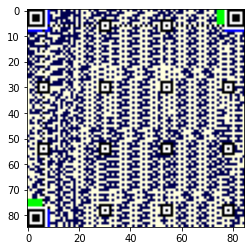

In [57]:
"""
irregularities:
 - L: 1
 - H: 1
 - M: 1
 - Q: 1
"""

version, out = make_groups("HELLO WORLD", ErrorCorrectionLevel.L, version=17)
print(f"{version=}")

matrix = np.full((calc_size(version), calc_size(version)), Module.empty)
place_function_patterns(matrix, version)
matrix = fill_qr_code(matrix, out, version)

print(f"{len(out)=}")
print()
display_QR(matrix)

len(bits4version)=208
len(bits4version)=208


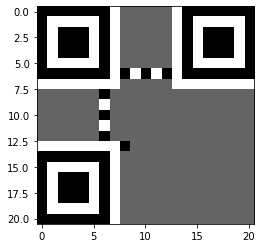

you should never have come here, but now that you are here ...
temp=208


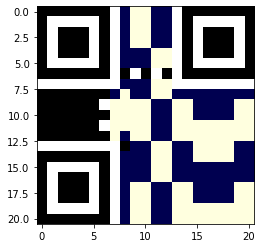

In [58]:
version = 1
ecl = ErrorCorrectionLevel.H

bits4version_len = len(make_groups("0", ecl, version=version)[1])
bits4version = '0000000011111111' * int(bits4version_len/16)
print(f"{len(bits4version)=}")
bits4version += "0" * (bits4version_len - len(bits4version))
print(f"{len(bits4version)=}")

# example_bits = "01000011111101101011011001000110010101011111011011100110111101110100011001000010111101110111011010000110000001110111011101010110010101110111011000110010110000100010011010000110000001110000011001010101111100100111011010010111110000100000011110000110001100100111011100100110010101110001000000110010010101100010011011101100000001100001011001010010000100010001001011000110000001101110110000000110110001111000011000010001011001111001001010010111111011000010011000000110001100100001000100000111111011001101010101010111100101001110101111000111110011000111010010011111000010110110000010110001000001010010110100111100110101001010110101110011110010100100110000011000111101111011011010000101100100111111000101111100010010110011101111011111100111011111001000100001111001011100100011101110011010101111100010000110010011000010100010011010000110111100001111111111011101011000000111100110101011001001101011010001101111010101001001101111000100010000101000000010010101101010001101101100100000111010000110100011111100000010000001101111011110001100000010110010001001111000010110001101111011000000000"
# # example_bits = "01000011111101101011011001000110010101011111011011100110111101110100011001000010111101110111011010000110000001110111011101010110010101110111011000110010110000100010011010000110000001110000011001010101111100100111011010010111110000100000011110000110001100100111011100100110010101110001000000110010010101100010011011101100000001100001011001010010000100010001001011000110000001101110110000000110110001111000011000010001011001111001001010010111111011000010011000000110001100100001000100000111111011001101010101010111100101001110101111000111110011000111010010011111000010110110000010110001000001010010110100111100110101001010110101110011110010100100110000011000111101111011011010000101100100111111000101111100010010110011101111011111100111011111001000100001111001011100100011101110011010101111100010000110010011000010100010011010000110111100001111111111011101011000000111100110101011001001101011010001101111010101001001101111000100010000101000000010010101101010001101101100100000111010000110100011111100000010000001101111011110001100000010110010001001111000010110001101111011000000000"
# example_bits = '0000000011111111' * int(len(example_bits)/16)

# example_bits = "01000000110001101000011001010110110001101100011011110010000001110111011011110111001001101100011001000010000100000000000011101100000100011110110000010001111011000001000111101100000100011110110000010001111011000001000111101100100100110011111100000011101101101111000100001001100001010010110011110000101011001000111010100000101010111000111011100110100001010000000"
# example_bits_len = len(example_bits)
# example_bits = '0000000011111111' * int(len(example_bits)/16)
# example_bits += "0" * (example_bits_len - len(example_bits))

# version = 2
matrix = np.full((calc_size(version), calc_size(version)), Module.empty)

place_function_patterns(matrix, version)
display_QR(matrix)

# matrix = fill_qr_code(matrix, example_bits, version)
matrix = fill_qr_code(matrix, bits4version, version)
# print(matrix)
display_QR(matrix)

In [59]:
# apply 8 masking patterns
# evaluate each pattern
# -> lowest penalty wins

# the penalty rules
# - 1x5 or 5x1
# - 2x2
# - alike finder patterns
# - ratio of black to white

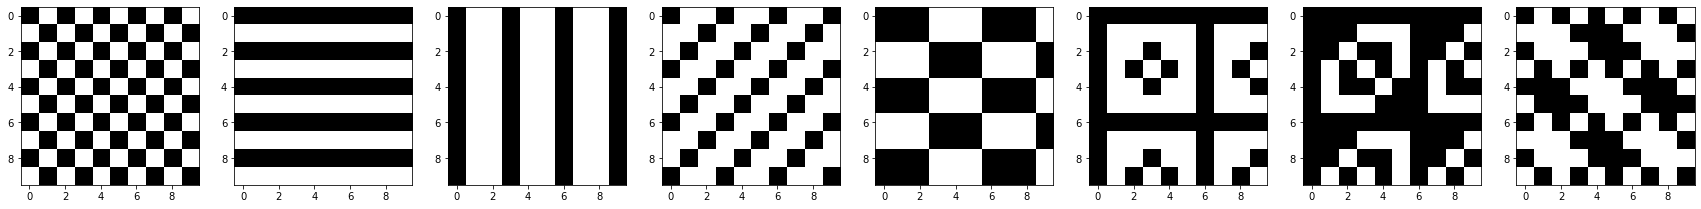

In [60]:
masking_conditions = [
    lambda row, column: (row + column) % 2 == 0,
    lambda row, column: row % 2 == 0,
    lambda row, column: column % 3 == 0,
    lambda row, column: (row + column) % 3 == 0,
    lambda row, column: ( int(row / 2) + int(column / 3) ) % 2 == 0,
    lambda row, column: ((row * column) % 2) + ((row * column) % 3) == 0,
    lambda row, column: ( ((row * column) % 2) + ((row * column) % 3) ) % 2 == 0,
    lambda row, column: ( ((row + column) % 2) + ((row * column) % 3) ) % 2 == 0
]

def apply_mask(matrix: np.ndarray, pattern_formula: Callable[[int, int], bool]):
    mat = matrix.copy()

    for (row_index, index), value in np.ndenumerate(mat):
        if pattern_formula(row_index, index):
            # toggle the module
            if value == Module.data_black:
                mat[row_index, index] = Module.data_white
            elif value == Module.data_white:
                mat[row_index, index] = Module.data_black
            if value == 1.:                         # TODO REMOVE
                mat[row_index, index] = 0           # TODO REMOVE

    return mat


fig, axs = plt.subplots(1, len(masking_conditions), figsize=(30,30))
m = np.ones((10,10))

for condition, ax in zip(masking_conditions, axs):
    n = apply_mask(m, condition)
    ax.imshow(n, cmap='gray')

plt.show()

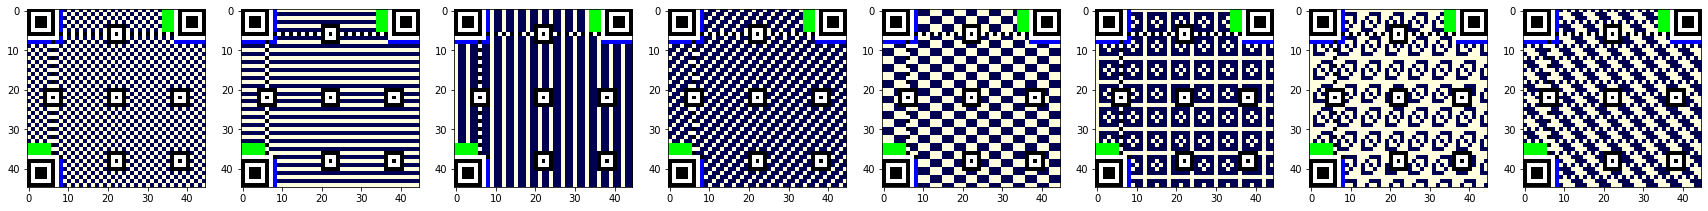

In [61]:
def make_empty(version=7, ecl=ErrorCorrectionLevel.H):
    bits4version_len = len(make_groups("0", ecl, version=version)[1])
    bits4version = '1111111111111111' * int(bits4version_len/16) + "0" * (bits4version_len - 16 * int(bits4version_len/16))

    matrix = np.full((calc_size(version), calc_size(version)), Module.empty)
    place_function_patterns(matrix, version)
    matrix = fill_qr_code(matrix, bits4version, version)
    return matrix

fig, axs = plt.subplots(1, len(masking_conditions), figsize=(30,30))

vecfunc = np.vectorize(lambda x: cmap[x])

for condition, ax in zip(masking_conditions, axs):
    matrix = make_empty(version=7)

    matrix = apply_mask(matrix, condition)

    # display
    rgb_arr = np.array(vecfunc(matrix))
    rgb_arr = rgb_arr.transpose(1, 2, 0)
    ax.imshow(rgb_arr, cmap='gray')

plt.show()

version=3


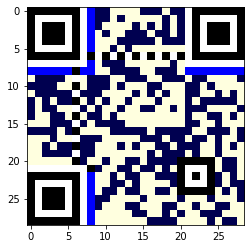

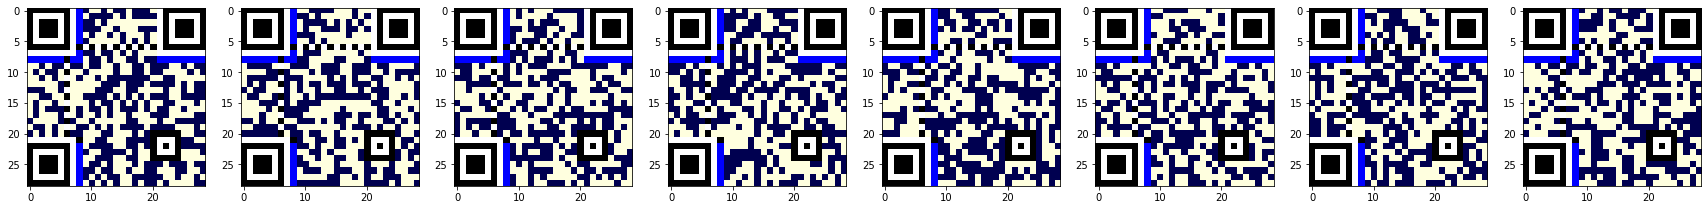

In [62]:
version, out = make_groups("The quick brown fox jumps over the lazy dog", ErrorCorrectionLevel.L)
print(f"{version=}")

matrix = np.full((calc_size(version), calc_size(version)), Module.empty)
place_function_patterns(matrix, version)
matrix = fill_qr_code(matrix, out, version)

display_QR(matrix)


fig, axs = plt.subplots(1, len(masking_conditions), figsize=(30,30))
vecfunc = np.vectorize(lambda x: cmap[x])

for condition, ax in zip(masking_conditions, axs):
    mat = matrix.copy()
    mat = apply_mask(mat, condition)

    # display
    rgb_arr = np.array(vecfunc(mat))
    rgb_arr = rgb_arr.transpose(1, 2, 0)
    ax.imshow(rgb_arr, cmap='gray')

plt.show()

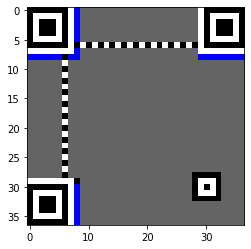

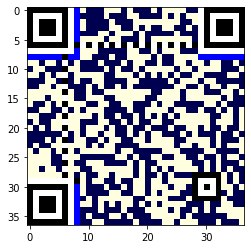

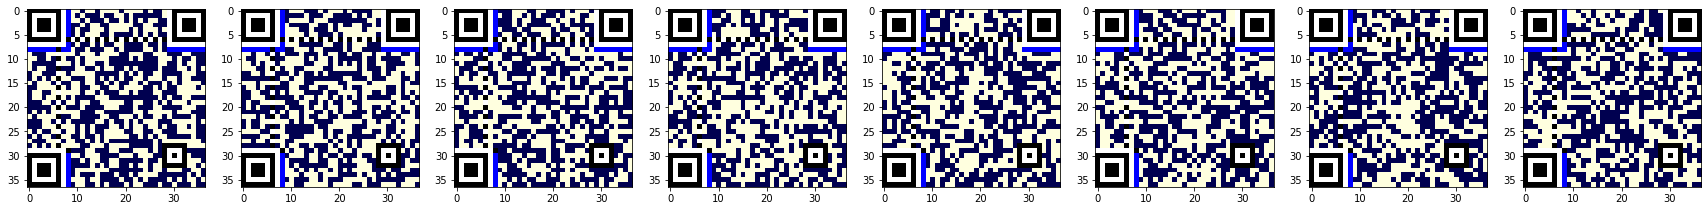

In [63]:
version = 5
ecl = ErrorCorrectionLevel.Q
example_bits = "01000011111101101011011001000110010101011111011011100110111101110100011001000010111101110111011010000110000001110111011101010110010101110111011000110010110000100010011010000110000001110000011001010101111100100111011010010111110000100000011110000110001100100111011100100110010101110001000000110010010101100010011011101100000001100001011001010010000100010001001011000110000001101110110000000110110001111000011000010001011001111001001010010111111011000010011000000110001100100001000100000111111011001101010101010111100101001110101111000111110011000111010010011111000010110110000010110001000001010010110100111100110101001010110101110011110010100100110000011000111101111011011010000101100100111111000101111100010010110011101111011111100111011111001000100001111001011100100011101110011010101111100010000110010011000010100010011010000110111100001111111111011101011000000111100110101011001001101011010001101111010101001001101111000100010000101000000010010101101010001101101100100000111010000110100011111100000010000001101111011110001100000010110010001001111000010110001101111011000000000"

# version = 2
matrix = np.full((calc_size(version), calc_size(version)), Module.empty)

place_function_patterns(matrix, version)
display_QR(matrix)

matrix = fill_qr_code(matrix, example_bits, version)
display_QR(matrix)


fig, axs = plt.subplots(1, len(masking_conditions), figsize=(30,30))
vecfunc = np.vectorize(lambda x: cmap[x])

for condition, ax in zip(masking_conditions, axs):
    mat = matrix.copy()
    mat = apply_mask(mat, condition)

    # display
    rgb_arr = np.array(vecfunc(mat))
    rgb_arr = rgb_arr.transpose(1, 2, 0)
    ax.imshow(rgb_arr, cmap='gray')

plt.show()

In [ ]:
get_total_codewords

In [64]:
def evaluation_condition_consecutive(matrix: np.ndarray):

    black = [Module.black, Module.data_black]
    white = [Module.white, Module.data_white]

    calc_score = lambda consecutive: 3+max(0, consecutive-5) if consecutive >= 5 else 0

    def horizontal() -> int:
        result = 0
        consecutive_type = None
        consecutive_num = 0

        for row in matrix:
            for element in row:
                print()
                print(f"{consecutive_num=}")
                print(f"{consecutive_type=}")
                print(f"{result=}")
                print(f"{element=}")
                if consecutive_type is None:
                    consecutive_type = element
                    consecutive_num = 1
                elif element in black:
                    if consecutive_type in black:
                        consecutive_num += 1
                    else:
                        consecutive_type = element
                        result += calc_score(consecutive_num)
                        if calc_score(consecutive_num) > 1:
                            print("scored")
                        print(f"{consecutive_num=}")
                        consecutive_num = 1
                elif element in white:
                    if consecutive_type in white:
                        consecutive_num += 1
                    else:
                        consecutive_type = element
                        result += calc_score(consecutive_num)
                        if calc_score(consecutive_num) > 1:
                            print("scored")
                        print(f"{consecutive_num=}")
                        consecutive_num = 1

            result += calc_score(consecutive_num)
            if calc_score(consecutive_num) > 1:
                print("scored")
            consecutive_type = None
            consecutive_num = 0 # should not be necesary, or maybe 1 ...
            print(f"{result=}")
            print("XXXXXXXXXXXXXXXXXXXXXX")
        
        return result


    def vertical() -> int:
        ...

    return horizontal() #+ vertical()

val = evaluation_condition_consecutive(matrix[:5])
print(f"{val=}")


consecutive_num=0
consecutive_type=None
result=0
element=<Module.black: 1>

consecutive_num=1
consecutive_type=<Module.black: 1>
result=0
element=<Module.black: 1>

consecutive_num=2
consecutive_type=<Module.black: 1>
result=0
element=<Module.black: 1>

consecutive_num=3
consecutive_type=<Module.black: 1>
result=0
element=<Module.black: 1>

consecutive_num=4
consecutive_type=<Module.black: 1>
result=0
element=<Module.black: 1>

consecutive_num=5
consecutive_type=<Module.black: 1>
result=0
element=<Module.black: 1>

consecutive_num=6
consecutive_type=<Module.black: 1>
result=0
element=<Module.black: 1>

consecutive_num=7
consecutive_type=<Module.black: 1>
result=0
element=<Module.white: 2>
scored
consecutive_num=7

consecutive_num=1
consecutive_type=<Module.white: 2>
result=5
element=<Module.reserved_for_format_information: 6>

consecutive_num=1
consecutive_type=<Module.white: 2>
result=5
element=<Module.data_white: 4>

consecutive_num=2
consecutive_type=<Module.white: 2>
result=5
elem

In [65]:
# 10 + 9 + 6 + 0 + 0 + 6 + 10 + 14
10 + 9 + 6 + 0 + 0

25

In [66]:
pattern1 = np.array([Module.white, Module.white, Module.white, Module.white, Module.black, Module.white, Module.black, Module.black, Module.black, Module.white, Module.black])
# pattern2 = pattern1.transpose() # Doesnt work
pattern2 = np.array([ # Not really needed anyway ...
    [Module.white],
    [Module.white],
    [Module.white],
    [Module.white],
    [Module.black],
    [Module.white],
    [Module.black],
    [Module.black],
    [Module.black],
    [Module.white],
    [Module.black]
])

In [67]:
def unify_blacks_and_whites(matrix: np.ndarray) -> np.ndarray:
    mat = matrix.copy()
    mat = np.where(mat == Module.data_black, Module.black, mat)
    mat = np.where(mat == Module.data_white, Module.white, mat)
    return mat

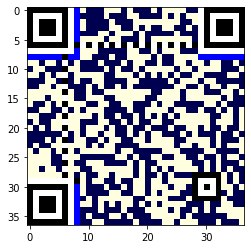

460.0


In [68]:
def evaluation_squares_patterns_ratio(matrix: np.ndarray) -> int:
    """ evaluation condition #2 (squares), #3 (patterns) and #4 (ratio)
    """

    mat = matrix.copy()

    penalty = 0

    num_total_modules = np.product(mat.shape)
    num_black_modules = 0

    for (row_index, index), value in np.ndenumerate(mat):

        if value == Module.black:
            num_black_modules += 1

        square = mat[row_index:row_index+2, index:index+2]
        if square.shape == (2, 2) and square[0, 0] == square[0, 1] == square[1, 0] == square[1, 1]:
        # if not(index+2 > len(mat[0]) or row_index+2 > len(mat)):
            penalty += 3
            # print(f"hit: {row_index, index=}")
        
        row = mat[row_index, index:index+11]
        if row.shape == (11,) and np.array_equal(row, pattern1):
            # print(f"WooW! {row_index, index=}")
            penalty += 40
            
        col = mat[row_index:row_index+11, index]
        if col.shape == (11,) and np.array_equal(col, pattern1):
            # print(f"here! {row_index, index=}")
            penalty += 40

    floor_div_res = (num_black_modules/num_total_modules*100) // 5
    ratio_penalty = min(abs(floor_div_res*5 - 50)/5, abs(floor_div_res*5 - 45)/5) * 10

    return penalty + ratio_penalty

# choices = np.array([Module.black, Module.white, Module.data_white, Module.data_black])
# arr = np.random.choice(choices, size=(10, 10))

# place_pattern(matrix, pattern2, (3, 3))
display_QR(matrix)
print(evaluation_squares_patterns_ratio(matrix))

37


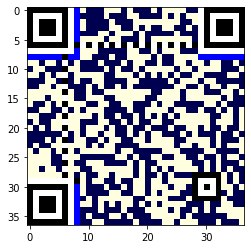

364

In [69]:
def evaluation_condition_1(matrix: np.ndarray) -> int:

    penalty = 0

    # horizontal
    for row_index in range(len(matrix)):
        last_module = None
        consecutive_chain_len = 1
        for index in range(len(matrix[0])):
            current_module = matrix[row_index, index]
            if last_module is None:
                last_module = current_module
            elif last_module == current_module:
                consecutive_chain_len += 1
            else:
                if consecutive_chain_len >= 5:
                    penalty += consecutive_chain_len -2

                last_module = current_module
                consecutive_chain_len = 1

        if consecutive_chain_len >= 5:
            penalty += consecutive_chain_len -2

    # vertical
    for index in range(len(matrix)):
        last_module = None
        consecutive_chain_len = 1
        for row_index in range(len(matrix[0])):
            current_module = matrix[row_index, index]
            if last_module is None:
                last_module = current_module
            elif last_module == current_module:
                consecutive_chain_len += 1
            else:
                if consecutive_chain_len >= 5:
                    penalty += consecutive_chain_len -2

                last_module = current_module
                consecutive_chain_len = 1

        if consecutive_chain_len >= 5:
            penalty += consecutive_chain_len -2


    return penalty

print(f"{len(matrix)}")
display_QR(matrix)
evaluation_condition_1(matrix)

In [97]:
print(masking_conditions[0])

<function <lambda> at 0x000001F238184940>


In [70]:
def calculate_penalty(matrix: np.ndarray) -> int:
    return evaluation_condition_1(matrix) + evaluation_squares_patterns_ratio(matrix)

In [93]:
def apply_best_mask(matrix: np.ndarray) -> tuple:

    penalties = []
    matrices = []

    for mask_pattern in masking_conditions:
        mat = apply_mask(matrix, mask_pattern)
        penalty = calculate_penalty(mat)
        penalties.append(penalty)
        matrices.append(mat)
    
    print(f"{penalties=}")
    index = np.argmin(penalties)
    print(f"{index=}")
    return matrices[index], index

    # only temporary function
    mask_pattern_num = 0
    matrix = apply_mask(matrix, masking_conditions[mask_pattern_num])
    return matrix, mask_pattern_num

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


version=1
you should never have come here, but now that you are here ...
temp=208
[0. 0. 0.]


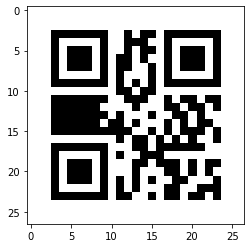

In [72]:
# version, out = make_groups("The quick brown fox jumps over the lazy dog", ErrorCorrectionLevel.L)
version, out = make_groups("HELLO WORLD", ErrorCorrectionLevel.L, version=1)

# FIXME: version 1 somehow iterates over too much data ...
# version, out = make_groups("HELLO WORLD", ErrorCorrectionLevel.L, version=1)
# version, out = make_groups("HELLO WORLD", ErrorCorrectionLevel.L)

print(f"{version=}")

matrix = np.full((calc_size(version), calc_size(version)), Module.empty)
place_function_patterns(matrix, version)
matrix = fill_qr_code(matrix, out, version)

# print(f"{len(out)=}")

matrix = apply_mask(matrix, masking_conditions[0])

matrix = np.where(matrix == Module.data_black, Module.black, matrix)
matrix = np.where(matrix == Module.data_white, Module.white, matrix)
# display
rgb_arr = np.array(vecfunc(matrix))
rgb_arr = rgb_arr.transpose(1, 2, 0)
print(rgb_arr[0, 0])
# mat = np.full((calc_size(version)+6, calc_size(version)+6), fill_value=[0., 0., 0.])
# mat = np.full((37, 37), fill_value=[0., 0., 0.])
mat = np.tile([255., 255., 255.], (calc_size(version)+6, calc_size(version)+6, 1))
place_pattern(mat, rgb_arr, (3,3))
plt.imshow(mat, cmap='gray')

# display_QR(matrix)

In [73]:
with open('../resources/format_information_string.pickle', 'rb') as file:
    # Load the array from the file using pickle
    format_information_string = pickle.load(file)

def get_format_information_string(error_correction_level: ErrorCorrectionLevel, mask_pattern_num: int) -> str:
    if not 0 <= mask_pattern_num <= 7:
        raise ValueError(f"mask_pattern_num must be in range 0 <= mask_pattern_num <= 7, not: {mask_pattern_num=}")
    return format_information_string[(error_correction_level, mask_pattern_num)]

assert get_format_information_string(ErrorCorrectionLevel.M, 0) == "101010000010010"

In [74]:
def place_format_information_string(matrix: np.ndarray, error_correction_level: ErrorCorrectionLevel, mask_pattern_num: int) -> np.ndarray:

    format_information_string = get_format_information_string(error_correction_level, mask_pattern_num)
    mat = matrix.copy()

    def format_information_string_generator(format_information_string: str) -> str:
        for bit in format_information_string:
            yield Module.white if bit == '0' else Module.black
        raise Exception("outside of bounds!!!")

    data = format_information_string_generator(format_information_string)

    index = 8
    for row_index in reversed(range(len(mat))):
        if mat[row_index, index] == Module.reserved_for_format_information:
            mat[row_index, index] = next(data)
    
    data = format_information_string_generator(format_information_string)
    
    row_index = 8
    for index in range(len(mat)):
        if mat[row_index, index] == Module.reserved_for_format_information:
            mat[row_index, index] = next(data)

    return mat

# place_format_information_string(matrix, get_format_information_string(ErrorCorrectionLevel.L, 4))

In [75]:
with open('../resources/version_information_string.pickle', 'rb') as file:
    # Load the array from the file using pickle
    version_information_string = pickle.load(file)

def get_version_information_string(version: int) -> str:
    if 6 < version < 41:
        return version_information_string[version]
    raise ValueError(f"version must be in range 6 < version < 41, not: {version=}")

assert get_version_information_string(7) == "000111110010010100"

In [76]:
def place_version_information_string(matrix: np.ndarray, version:int) -> np.ndarray:
    if not 6 < version < 41:
        raise ValueError(f"version must be in range 6 < version < 41, not {version}")

    def version_information_string_generator(version_information_string: str) -> str:
        for bit in version_information_string:
            yield Module.white if bit == '0' else Module.black
        raise Exception("outside of bounds!!!")

    mat = matrix.copy()
    size = calc_size(version)
    version_information_string = get_version_information_string(version)

    # top_right
    data = version_information_string_generator(version_information_string)
    for row_index in reversed(range(0, 6)):
        for index in reversed(range(size-11, size-8)):
            mat[row_index, index] = next(data)

    # bottom_left
    data = version_information_string_generator(version_information_string)
    for index in range(0, 6):
        for row_index in range(size-11, size-8):
            mat[row_index, index] = next(data)
    
    return mat

# display_QR(place_version_information_string(matrix, 15))

version=7
penalties=[951.0, 1295.0, 1086.0, 1120.0, 1094.0, 1113.0, 1083.0, 1101.0]
index=0
mask_pattern_num=0


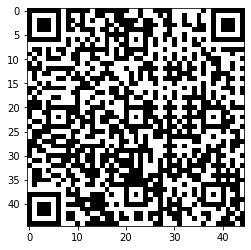

In [102]:
# LAYOUT PHASE

error_correction_level = ErrorCorrectionLevel.Q
# version, out = make_groups("asdfasfdasdf", error_correction_level, version=2)
# version, out = make_groups("https://www.qrcode.com/", error_correction_level)
# version, out = make_groups("HELLO WORLD", error_correction_level, version=5)
version, out = make_groups("HELLO WORLD", error_correction_level, version=7)
# version, out = make_groups("HELLO WORLD", error_correction_level, version=1) # FIXME: this should use mask pattern number 6

print(f"{version=}")

matrix = np.full((calc_size(version), calc_size(version)), Module.empty)
place_function_patterns(matrix, version)
matrix = fill_qr_code(matrix, out, version)

if version >= 7:
    matrix = place_version_information_string(matrix, version)

matrix, mask_pattern_num = apply_best_mask(matrix)
print(f"{mask_pattern_num=}")
matrix = place_format_information_string(matrix, error_correction_level, mask_pattern_num)
matrix = unify_blacks_and_whites(matrix)

display_QR(matrix)

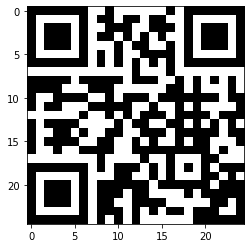

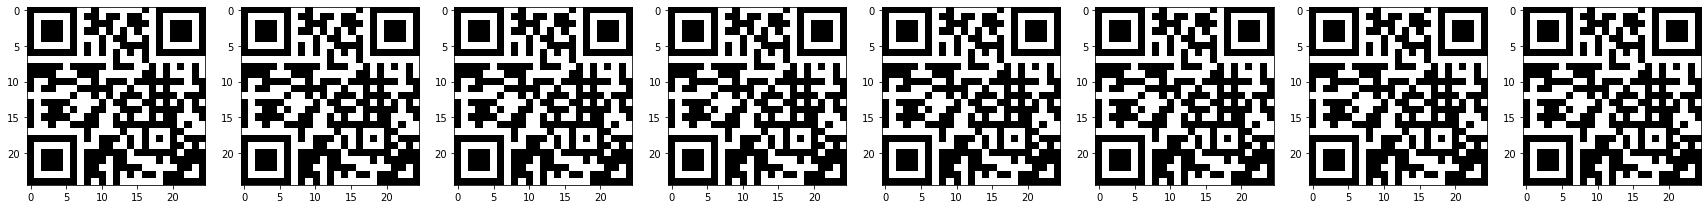

In [78]:
display_QR(matrix)


fig, axs = plt.subplots(1, len(masking_conditions), figsize=(30,30))
vecfunc = np.vectorize(lambda x: cmap[x])

for condition, ax in zip(masking_conditions, axs):
    mat = matrix.copy()
    mat = apply_mask(mat, condition)

    # display
    rgb_arr = np.array(vecfunc(mat))
    rgb_arr = rgb_arr.transpose(1, 2, 0)
    ax.imshow(rgb_arr, cmap='gray')

plt.show()

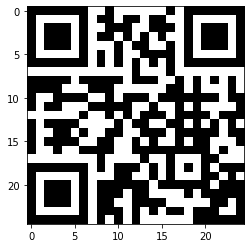

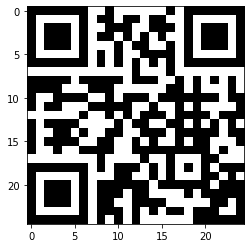

In [79]:
display_QR(matrix)
mat = apply_mask(matrix, masking_conditions[0])
display_QR(mat)

In [112]:
values = [Module.black, Module.white]
arr = np.random.choice(values, size=(5, 5))
arr

array([[<Module.black: 1>, <Module.black: 1>, <Module.white: 2>,
        <Module.white: 2>, <Module.white: 2>],
       [<Module.white: 2>, <Module.white: 2>, <Module.black: 1>,
        <Module.white: 2>, <Module.white: 2>],
       [<Module.white: 2>, <Module.white: 2>, <Module.black: 1>,
        <Module.white: 2>, <Module.white: 2>],
       [<Module.black: 1>, <Module.black: 1>, <Module.black: 1>,
        <Module.black: 1>, <Module.white: 2>],
       [<Module.black: 1>, <Module.white: 2>, <Module.white: 2>,
        <Module.white: 2>, <Module.black: 1>]], dtype=object)

In [117]:
np.where(arr == Module.black, 0, 1)

array([[0, 0, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 1, 0]])

In [119]:
arr = np.random.randint(low=0, high=256, size=(3, 3, 3), dtype=np.uint8)
arr

array([[[234, 150,  61],
        [214, 211, 153],
        [ 45,  94,  86]],

       [[ 21, 233, 180],
        [248, 135, 187],
        [ 59, 133,  17]],

       [[ 44, 203,  68],
        [191,  35,  72],
        [ 86, 106, 201]]], dtype=uint8)